In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import sklearn
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


# Prepare data

In [2]:
df = pd.read_csv('../data/Men_Long.csv')

# Split the dataset into higher-performance vs. lower-performance riders
split = df.groupby('Rider ID').agg({'Price': 'median', 'Score': ['median', 'count', np.count_nonzero]})
split['pct_nonzero'] = split[('Score', 'count_nonzero')] / split[('Score', 'count')]

# Keep only high-performance riders (we will later fill in some generic assumption for low-performance riders)
df = df[df['Rider ID'].isin(split[(split[('Price', 'median')] > 1) \
                                  & (split[('Score', 'median')] > 99) & (split['pct_nonzero'] > 0.5)].index)]

# Z-score and sqrt-transform numerical variables
df['Age'] = scale(df['Age'])
for field in ['Price', 'Score 1ya', 'Score']:
    df[field] = scale(df[field]**0.5)
#     df[field] = scale(np.log(df[field] + 1)) # could do log instead

# One-hot encode categorical variables
df = pd.get_dummies(df.drop('Rider Name', axis = 1))

df

,Year,Rider ID,Age,Price,Score 1ya,Score,Country_ARG,Country_AUS,Country_AUT,Country_BEL,...,UCI Team_WGN,UCI Team_WIL,UCI Team_WVA,UCI Team_XAC,UCI Team_XYZ,UCI Team_YEL,UCI Team_ZZZ,UCI Cat_CONT,UCI Cat_PROF,UCI Cat_WT
0,2010,1.0,-0.177201,2.599594,2.461370,2.254926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2011,1.0,0.044128,2.311484,2.236683,2.835756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2012,1.0,0.265457,2.457942,2.827685,1.847519,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2013,1.0,0.486786,2.599594,1.822141,1.072212,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2014,1.0,0.708115,1.293029,1.033254,2.830965,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12759,2020,3770.0,-0.619858,-0.746074,0.105276,-1.399711,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12905,2017,3811.0,-1.062516,-1.072715,-1.481964,-0.480520,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12906,2018,3811.0,-0.841187,-1.072715,-0.546674,0.160208,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12907,2019,3811.0,-0.619858,-0.284133,0.105276,-0.420007,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
df = pd.read_csv('../data/Men_Long.csv')

# Split the dataset into higher-performance vs. lower-performance riders
split = df.groupby('Rider ID').agg({'Price': 'median', 'Score': ['median', 'count', np.count_nonzero]})
split['pct_nonzero'] = split[('Score', 'count_nonzero')] / split[('Score', 'count')]

# Keep only high-performance riders (we will later fill in some generic assumption for low-performance riders)
df = df[df['Rider ID'].isin(split[(split[('Price', 'median')] > 1) \
                                  & (split[('Score', 'median')] > 99) & (split['pct_nonzero'] > 0.5)].index)]

# Z-score and sqrt-transform numerical variables
df['Age'] = scale(df['Age'])
for field in ['Price', 'Score 1ya', 'Score']:
    df[field] = scale(df[field]**0.5)
#     df[field] = scale(np.log(df[field] + 1)) # could do log instead

# Drop categorical variables
df = df.drop(['Rider Name', 'Country', 'UCI Team', 'UCI Cat'], axis = 1)

df

,Year,Rider ID,Age,Price,Score 1ya,Score
0,2010,1.0,-0.177201,2.599594,2.461370,2.254926
1,2011,1.0,0.044128,2.311484,2.236683,2.835756
2,2012,1.0,0.265457,2.457942,2.827685,1.847519
3,2013,1.0,0.486786,2.599594,1.822141,1.072212
4,2014,1.0,0.708115,1.293029,1.033254,2.830965
...,...,...,...,...,...,...
12759,2020,3770.0,-0.619858,-0.746074,0.105276,-1.399711
12905,2017,3811.0,-1.062516,-1.072715,-1.481964,-0.480520
12906,2018,3811.0,-0.841187,-1.072715,-0.546674,0.160208
12907,2019,3811.0,-0.619858,-0.284133,0.105276,-0.420007


In [44]:
train_df = df[df['Year'] < 2019] # train on 2010-2018 data
test_df = df[(df['Year'] > 2010) & (df['Year'] < 2020)] # test on 2011-2019 data

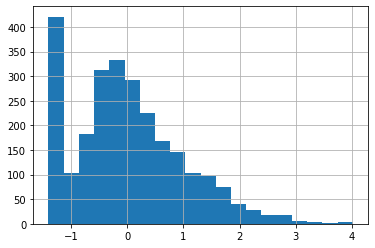

In [45]:
df['Score'].hist(bins = 20)

In [46]:
def build_data(df, pad_value=-99):
    data = []
    labels = []

    for rider_id in df['Rider ID'].unique():
        this_df = df[df['Rider ID'] == rider_id]
        data.append(this_df.iloc[:, 3:].drop('Score', axis = 1).to_numpy())
        labels.append(this_df.loc[:, 'Score'].to_numpy())
        if not rider_id % 100:
            print('Processed rider ID', rider_id)

    data = pad_sequences(data, value = pad_value, dtype='float64')
    labels = pad_sequences(labels, value = pad_value, dtype='float64')
    return data, labels

In [47]:
train_X, train_y = build_data(train_df)

Processed rider ID 2700.0


In [48]:
train_X[250][5][0]

-1.0727148602690395

In [49]:
train_X.shape

(319, 9, 2)

# Specify, train, and apply model

In [50]:
n_batch = 32
n_epoch = 100
n_neurons = 256

# design network
model = Sequential()
model.add(Masking(-99, input_shape = train_X.shape[1:]))
model.add(LSTM(n_neurons, return_sequences = True))
model.add(LSTM(n_neurons // 2, return_sequences = False))
model.add(Dense(train_y.shape[-1]))
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

# fit network
model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=False)

Epoch 1/100
319/319 [==============================] - 2s 6ms/step - loss: 2484.9031
Epoch 2/100
319/319 [==============================] - 1s 2ms/step - loss: 2471.4697
Epoch 3/100
319/319 [==============================] - 1s 2ms/step - loss: 2380.4572
Epoch 4/100
319/319 [==============================] - 1s 2ms/step - loss: 2236.8755
Epoch 5/100
319/319 [==============================] - 1s 2ms/step - loss: 2143.7629
Epoch 6/100
319/319 [==============================] - 1s 2ms/step - loss: 2079.2772
Epoch 7/100
319/319 [==============================] - 1s 2ms/step - loss: 2026.4012
Epoch 8/100
319/319 [==============================] - 1s 2ms/step - loss: 1980.3950
Epoch 9/100
319/319 [==============================] - 1s 2ms/step - loss: 1939.8030
Epoch 10/100
319/319 [==============================] - 1s 2ms/step - loss: 1902.0783
Epoch 11/100
319/319 [==============================] - 1s 2ms/step - loss: 1868.0064
Epoch 12/100
319/319 [==============================] - 1s 2ms/

319/319 [==============================] - 1s 2ms/step - loss: 1278.4493
Epoch 97/100
319/319 [==============================] - 1s 2ms/step - loss: 1277.1125
Epoch 98/100
319/319 [==============================] - 1s 2ms/step - loss: 1275.8520
Epoch 99/100
319/319 [==============================] - 1s 2ms/step - loss: 1274.4608
Epoch 100/100
319/319 [==============================] - 1s 2ms/step - loss: 1273.2139


In [58]:
 np.linalg.norm(train_X)

3778.1612663818037

In [10]:
model.save_weights('weights.h5')

In [51]:
test_X, test_y = build_data(test_df)

Processed rider ID 2700.0


In [52]:
yhat = model.predict(test_X)#, batch_size=1)
yhat.shape

(317, 9)

In [53]:
final_predictions = pd.Series([array[-1] for array in yhat])
validation_df = test_df.groupby('Rider ID')[['Score 1ya', 'Score']].agg('last')
validation_df = validation_df.reset_index()
validation_df = pd.concat([validation_df, final_predictions], axis = 1).set_index('Rider ID')
validation_df

,Score 1ya,Score,0
Rider ID,,,
1.0,2.106432,1.847519,0.003081
2.0,3.398783,3.035327,-0.012003
3.0,0.201559,1.737412,0.053970
4.0,-0.782057,-1.139725,-0.012426
5.0,0.612752,1.107508,0.116986
...,...,...,...
3727.0,-0.298905,0.736296,0.017365
3754.0,-0.443834,1.083126,0.018094
3761.0,1.292556,1.124971,0.016780


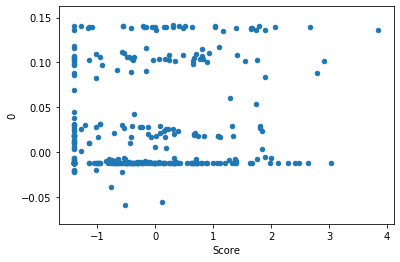

In [54]:
validation_df.plot('Score', 0, kind = 'scatter')

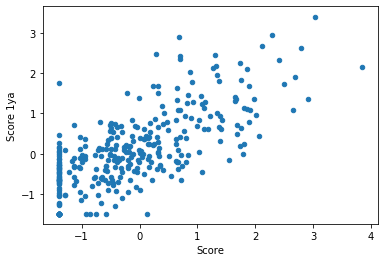

In [55]:
validation_df.plot('Score', 'Score 1ya', kind = 'scatter')

In [ ]:
# I wrote this first but I think I'm not meant to use it - think RNNs 
# learn from each time step whether or not it's the last one in a sequence

def build_data_duplicates(df, pad_value=-99):
    data = []
    labels = []

    for rider_id in df['Rider ID'].unique():
        this_df = df[df['Rider ID'] == rider_id]
        while len(this_df):
            data.append(this_df.iloc[:, 3:].drop('Score', axis = 1).to_numpy())
            labels.append(this_df.loc[:, 'Score'].to_numpy())
            this_df = this_df[:-1]
        if not rider_id % 100:
            print('Processed rider ID', rider_id)
#         data.append(np.array(df[df['Rider ID'] == rider_id].iloc[:, 3:-1]))
#         labels.append(np.array(df[df['Rider ID'] == rider_id].iloc[:, -1]))

#     data = np.array(data)
#     labels = np.array(labels)
    data = pad_sequences(data, value = pad_value)
    labels = pad_sequences(labels, value = pad_value)
#     labels = labels.reshape(labels.shape + (1,))
    return data, labels

In [ ]:
# I still think there is some merit to the batch_size = 1 concept
# so I wrote this, but I couldn't figure out how to get it working :(

def build_data_unpadded(df):
    data = []
    labels = []

    for rider_id in df['Rider ID'].unique():
        this_df = df[df['Rider ID'] == rider_id]
        data.append(this_df.iloc[:, 3:].drop('Score', axis = 1).to_numpy())
        labels.append(this_df.loc[:, 'Score'].to_numpy())
        if not rider_id % 100:
            print('Processed rider ID', rider_id)
            
#     data = np.array(data)
#     labels = np.array(labels)
    return data, labels